In [58]:
import re
import random
import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt

from collections import Counter

RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

pd.set_option("display.max_colwidth", 120)


# Import dataset

In [59]:
DATA_PATH = "../data/raw/spam.csv"

df_raw = pd.read_csv(DATA_PATH, encoding="latin-1")
df_raw.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std t...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives around here though",NaN,NaN,NaN


## Overview

In [60]:
# Nombre de  valeurs manquantes
valeurs_manquantes = df_raw.isna().sum()
valeurs_manquantes

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [61]:
# Pourcentage de valeurs manquantes
valeurs_manquantes_pourcent = (df_raw.isna().sum() / df_raw.shape[0]) * 100
valeurs_manquantes_pourcent

v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

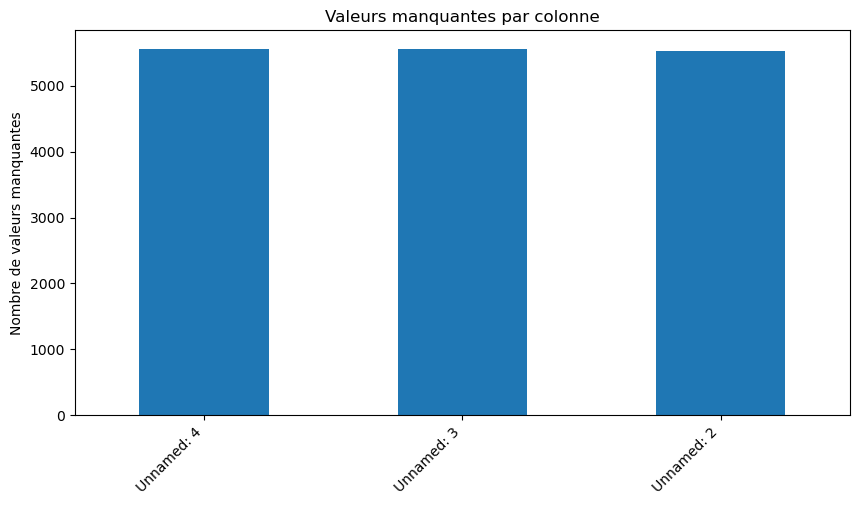

In [62]:
valeurs_manquantes_graph = valeurs_manquantes[valeurs_manquantes > 0].sort_values(ascending=False)

plt.figure(figsize=(10, 5))
# Prise en charge si valeurs manquetes à 0
if valeurs_manquantes_graph.empty:
    ax = plt.gca()
    ax.text(0.5, 0.5, "Aucune valeur manquante",
            ha="center", va="center", fontsize=12)
    ax.axis("off")
else:
    valeurs_manquantes_graph.plot(kind="bar")
    plt.title("Valeurs manquantes par colonne")
    plt.ylabel("Nombre de valeurs manquantes")
    plt.xticks(rotation=45, ha="right")

plt.show()

In [63]:
# Détection des noms de colonnes numériques ou catégorielles
numeric_features = df_raw.select_dtypes(exclude="object").columns
categorical_features = df_raw.select_dtypes(include="object").columns

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  Index([], dtype='object')
Found categorical features  Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')


In [64]:
# Vérification valeurs numériques float uniques
numeric_float = df_raw.select_dtypes('float64')

for col in numeric_float.columns:
  print(f"Colonne {col} : ", numeric_float[col].nunique())

In [65]:
# Vérification valeurs numériques int uniques
numeric_int = df_raw.select_dtypes('int64')

for col in numeric_int.columns:
  print(f"Colonne {col} : ", numeric_int[col].nunique())

In [66]:
# Vérification valeurs non numériques float uniques
non_numeric = df_raw.select_dtypes('object')

for col in non_numeric.columns:
  print(f"Colonne {col} : ", non_numeric[col].nunique())

Colonne v1 :  2
Colonne v2 :  5169
Colonne Unnamed: 2 :  43
Colonne Unnamed: 3 :  10
Colonne Unnamed: 4 :  5


# Cleaning

In [67]:
# Sélection des colonnes utiles
use_cols = [c for c in df_raw.columns if c in ("v1", "v2")]
if len(use_cols) < 2:
    use_cols = list(df_raw.columns[:2])

# Normalisation des noms de colonnes
df = df_raw[use_cols].copy()
df.columns = ["label", "text"]  

# Nettoyage des valeurs
df["label"] = df["label"].astype(str).str.strip().str.lower()
df["text"] = df["text"].astype(str)

# Filtrage sur ham/spam
df = df[df["label"].isin(["ham", "spam"])].copy()

# Mapping numérique des labels (0=ham, 1=spam)
df["y"] = df["label"].map({"ham": 0, "spam": 1}).astype(int)

# Nettoyage du texte
df["text"] = df["text"].str.replace(r"\s+", " ", regex=True).str.strip()

df.head()


,label,text,y
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std t...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives around here though",0


In [68]:

df.shape

(5572, 3)

In [69]:
df.to_csv("../data/outputs/spam_cleaned.csv")

# EDA

## Distribution des classes

In [70]:
counts = df["label"].value_counts()
props = df["label"].value_counts(normalize=True).mul(100).round(2)

eda_imbalance = pd.DataFrame({
    "count": counts,
    "pct_%": props
})

In [71]:
imb_df = (
    df["label"]
    .value_counts()
    .rename_axis("label")
    .reset_index(name="count")
)
imb_df["pct"] = (imb_df["count"] / imb_df["count"].sum() * 100).round(2)

fig = px.bar(
    imb_df, x="label", y="count", text="pct",
    title="Equillibre des classes (ham vs spam)"
)
fig.update_traces(texttemplate="%{text}%", textposition="outside")
fig.update_layout(yaxis_title="Count", xaxis_title="Label", uniformtext_minsize=10, uniformtext_mode="hide")
fig.show()


## Distribution des longueurs de SMS

In [72]:
df["n_chars"] = df["text"].str.len()
df["n_words"] = df["text"].str.split().str.len()

summary_global = df[["n_chars", "n_words"]].describe().T
summary_by_label = df.groupby("label")[["n_chars", "n_words"]].describe()

summary_global, summary_by_label

(          count       mean        std  min   25%   50%    75%    max
 n_chars  5572.0  80.006102  59.595079  2.0  35.0  61.0  121.0  910.0
 n_words  5572.0  15.494436  11.329427  1.0   7.0  12.0   23.0  171.0,
       n_chars                                                           \
         count        mean        std   min    25%    50%    75%    max   
 label                                                                    
 ham    4825.0   70.899896  57.890645   2.0   33.0   52.0   92.0  910.0   
 spam    747.0  138.824632  29.165701  13.0  132.5  149.0  157.0  224.0   
 
       n_words                                                      
         count       mean        std  min   25%   50%   75%    max  
 label                                                              
 ham    4825.0  14.200622  11.424511  1.0   7.0  11.0  19.0  171.0  
 spam    747.0  23.851406   5.811898  2.0  22.0  25.0  28.0   35.0  )

In [73]:
fig = px.histogram(
    df,
    x="n_chars",
    color="label",
    nbins=60,
    barmode="overlay",
    opacity=0.6,
    title="Distribution des longueurs de SMS (characters)"
)
fig.update_layout(xaxis_title="Number of characters", yaxis_title="Count")
fig.show()

In [74]:
# 3) Moyennes / médianes simples par classe (lisible)
agg = df.groupby("label").agg(
    n=("text", "size"),
    avg_chars=("n_chars", "mean"),
    med_chars=("n_chars", "median"),
    avg_words=("n_words", "mean"),
    med_words=("n_words", "median"),
)

# arrondi pour présentation
agg = agg.round({"avg_chars": 1, "avg_words": 1})
agg


,n,avg_chars,med_chars,avg_words,med_words
label,,,,,
ham,4825,70.9,52.0,14.2,11.0
spam,747,138.8,149.0,23.9,25.0


In [75]:
df_plot = df.sample(min(len(df), 2000), random_state=RANDOM_STATE)
fig = px.scatter(
    df_plot,
    x="n_words", y="n_chars",
    color="label",
    opacity=0.6,
    title="Words vs Characters (sampled)",
    hover_data={"text": True, "n_words": True, "n_chars": True, "label": True}
)
fig.update_layout(xaxis_title="Number of words", yaxis_title="Number of characters")
fig.show()


## Analyse mots les plus fréquents par classe

In [76]:
def top_words(texts, top_n=15):
    tokens = []
    for t in texts:
        t = t.lower()
        # garde lettres + chiffres (conserve les signaux type "free", "txt", "150p", etc.)
        toks = re.findall(r"[a-z0-9']+", t)
        tokens.extend(toks)
    return Counter(tokens).most_common(top_n)

top_ham = top_words(df.loc[df["label"]=="ham", "text"].tolist(), top_n=20)
top_spam = top_words(df.loc[df["label"]=="spam", "text"].tolist(), top_n=20)

pd.DataFrame({"top_ham": top_ham, "top_spam": top_spam})


,top_ham,top_spam
0,"(i, 2319)","(to, 688)"
1,"(you, 1862)","(a, 378)"
2,"(to, 1554)","(call, 355)"
3,"(the, 1122)","(you, 290)"
4,"(a, 1057)","(your, 264)"
5,"(u, 1004)","(free, 224)"
6,"(and, 857)","(2, 206)"
7,"(in, 818)","(the, 206)"
8,"(me, 772)","(for, 204)"
9,"(my, 750)","(now, 202)"
